# Simulations of optically-induced demagnetization
Here, we simulate the optically-induced demagnetization within the microscopic three temperature model (M3TM) introduced by Koopmans and others. For simplicity, we ignore z-dependence.

The M3TM equations are given in (Koopmans 2010) as
\begin{equation}
C_e[T_e] = \gamma T_e
\end{equation}
\begin{equation}
C_e\frac{dT_e}{dt} = \frac{\partial}{\partial z}\left(\kappa \frac{\partial}{\partial z}T_e\right)+g_{ep}[T_p-T_e]+P_{pump}
\end{equation}
\begin{equation}
C_p\frac{dT_p}{dt} =g_{ep}[T_e-T_p]
\end{equation}
\begin{equation}
\frac{dm}{dt} = Rm\frac{T_P}{T_C}\left[1-m\coth\left(\frac{mT_C}{T_e}\right)\right]
\end{equation}

To simplify modelling, we neglect z-dependence, giving
\begin{equation}
C_e[T_e]\frac{dT_e}{dt} = g_{e-ph}[T_p-T_e]+P(t)
\end{equation}
\begin{equation}
C_{ph}\frac{dT_{ph}}{dt} = g_{e-ph}[T_e-T_p]
\end{equation}
\begin{equation}
\frac{dm}{dt} = Rm\frac{T_p}{T_C}\left[1-m\coth\left(\frac{mT_C}{T_e}\right)\right]
\end{equation}

In [1]:
# Import standard python modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import sys
sys.path.append('../')
import visualize
visualize.set_plot_params.init_paper_small()

/Users/dhigley/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Material constants, as taken from D. J. Higley's thesis, p. 59
Co_constants = {'Cp': 2.07*1E6,
                'gamma': 665,
                'g_ep': 405*1E6,
                'TC': 1388,
                'R': 25.3*1E12}
Co_Pt_constants = {'Cp': 2.98*1E6,
                   'gamma': 720,
                   'g_ep': 264*1E6,
                   'TC': 550,
                   'R': 9.396*1E12}

"""Units:
Cp: Jm^(-3)K^(-1)
gamma: Jm^(-3)K^(-2)
g_ep: J(sm^3K)^(-1)
TC: K
R: s^(-1)
"""

"""Definitions:
Cp: lattice heat capacity
gamma: Ce = gamma*Te with Ce being the electronic heat capacity, and Te the electronic temperature
g_ep: electron-phonon coupling constant
TC: Curie temperature
R: material-specific scaling factor of demagnetization rate
"""

"""Conversion from J/m^3 to eV/atom:
x [J/m^3] = (x [eV/atom])(rho [atoms/nm^3])(10^27 [nm^3/m^3])(1.602*10^(-19) [J/eV])
or
x [J/m^3] = (x [eV/atom])(rho [atoms/nm^3])(1.602*10^(8))
where rho is the atomic density in atoms/nm^3

Cobalt has 90.5 atoms/nm^3
-> 260 meV/atom = 3.769 GJ/m^3
, 278.6 meV/atom = 4.039 GJ/m^3

Co/Pt has 77.4 atoms/nm^3
-> 260 meV/atom = 3.224 GJ/m^3
, 278.6 meV/atom = 3.454 GJ/m^3
"""

'Conversion from J/m^3 to eV/atom:\nx [J/m^3] = (x [eV/atom])(rho [atoms/nm^3])(10^27 [nm^3/m^3])(1.602*10^(-19) [J/eV])\nor\nx [J/m^3] = (x [eV/atom])(rho [atoms/nm^3])(1.602*10^(8))\nwhere rho is the atomic density in atoms/nm^3\n\nCobalt has 90.5 atoms/nm^3\n-> 260 meV/atom = 3.769 GJ/m^3\n, 278.6 meV/atom = 4.039 GJ/m^3\n\nCo/Pt has 77.4 atoms/nm^3\n-> 260 meV/atom = 3.224 GJ/m^3\n, 278.6 meV/atom = 3.454 GJ/m^3\n'

In [3]:
class M3TM_Sample:
    """Numerically calculate sample properties within 'microscopic 3 temperature model' (M3TM)
    Neglects z-dependence for simplicity.
    Uses Euler method to solve the first-order differential equations given
    by the microscopic three temperature model.
    """
    
    def __init__(self, material_constants, Te, Tph, t0=0):
        self.material_constants = material_constants
        self.Te = Te
        self.Tph = Tph
        self.m = self._calc_initial_m()
        self.t = t0
        # history will keep track of the previous states of the sample
        # so that they can be plotted and such.
        self.history = {'t': [self.t],
                        'Te': [self.Te],
                        'Tph': [self.Tph],
                        'm': [self.m]}
        
    def _calc_initial_m(self):
        """Calculate the initial value of the magnetization (m).
        Finds m as the value when dm/dt = 0 for the initial conditions"""
        
        def set_to_zero(m):
            return 1-m*(1/np.tanh(m*self.material_constants['TC']/self.Te))
        
        sol = optimize.root(set_to_zero, [1])
        return sol.x[0]
        
    def step_t(self, delta_t, abs_energy_density):
        self.t = self.t+delta_t
        self._update_Te(delta_t, abs_energy_density)
        self._update_Tph(delta_t)
        self._update_m(delta_t)
        self._update_history()
    

    def _update_Te(self, delta_t, abs_energy_density):
        mc = self.material_constants
        Ce = mc['gamma']*self.Te
        dTe_dt = (mc['g_ep']*(self.Tph-self.Te)+abs_energy_density)/Ce
        delta_Te = dTe_dt*delta_t
        self.Te = self.Te+delta_Te

    def _update_Tph(self, delta_t):
        mc = self.material_constants
        dTph_dt = (mc['g_ep']*(self.Te-self.Tph))/mc['Cp']
        delta_Tph = dTph_dt*delta_t
        self.Tph = self.Tph+delta_Tph

    def _update_m(self, delta_t):
        mc = self.material_constants
        factor = 1-self.m*(1/np.tanh(self.m*mc['TC']/self.Te))
        dm_dt = mc['R']*self.m*(self.Tph/mc['TC'])*factor
        delta_m = dm_dt*delta_t
        self.m = self.m+delta_m
    
    def _update_history(self):
        self.history['t'].append(self.t)
        self.history['Te'].append(self.Te)
        self.history['Tph'].append(self.Tph)
        self.history['m'].append(self.m)

In [4]:
def make_pulse(times, integrated_strength, fwhm=10E-15):
    """Return a Gaussian pulse with the specified integrated strength and fwhm"""
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))
    gauss = np.exp(-(times**2)/(2*(sigma)**2))
    gauss_integral = np.trapz(gauss, times)
    pulse = gauss*integrated_strength/gauss_integral
    return pulse

In [5]:
# Run simulations for Co and Co_Pt
times = np.linspace(-100E-15, 100E-15, 1E5)
delta_t = times[1]-times[0]
Co_sample = M3TM_Sample(Co_constants, 273.15, 273.15, t0=times[0])
Co_Pt_sample = M3TM_Sample(Co_Pt_constants, 273.15, 273.15, t0=times[0])
total_abs_energy_density_Co = 4.039E9  # J/m^3
total_abs_energy_density_Co_pt = 3.454E9  # J/m^3
Co_pulse = make_pulse(times, total_abs_energy_density_Co, fwhm=39E-15)
Co_pt_pulse = make_pulse(times, total_abs_energy_density_Co_pt, fwhm=39E-15)
for ind, t in enumerate(times[1:]):
    Co_sample.step_t(delta_t, Co_pulse[ind])
    Co_Pt_sample.step_t(delta_t, Co_pt_pulse[ind])    

/Users/dhigley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [6]:
def calc_integrated_pulse_magnetization(pulse, magnetization):
    """Calculate the average magnetization that would be measured by the input pulse"""
    measured = np.trapz(pulse*magnetization)/np.trapz(pulse)
    measured = measured/magnetization[0]    # normalize to starting value of magnetization
    return measured

def calc_integrated_pulse_temperature(pulse, temperature):
    measured = np.trapz(pulse*temperature)/np.trapz(pulse)
    return measured

# Calculate magnetization that would be measured in Co and Co/Pt cases
Co_measured_magnetization = calc_integrated_pulse_magnetization(Co_pulse, Co_sample.history['m'])
print(Co_measured_magnetization)
Co_Pt_measured_magnetization = calc_integrated_pulse_magnetization(Co_pt_pulse, Co_Pt_sample.history['m'])
print(Co_Pt_measured_magnetization)

0.9217446105712218
0.7653202215957867


2343.8540554475367
2087.7056974449133


/Users/dhigley/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


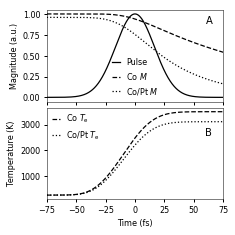

In [7]:
# Make a summary figure for 2019 manuscript
#% matplotlib auto
f, axs = plt.subplots(2, 1, sharex=True, figsize=(3.37, 3.37))
axs[0].plot(times*1E15, Co_pulse/np.amax(Co_pulse), 'k', label='Pulse')
axs[0].plot(times*1E15, Co_sample.history['m'], '--k', label='Co $M$')
axs[0].plot(times*1E15, Co_Pt_sample.history['m'], ':k', label='Co/Pt $M$')
axs[0].legend(loc='lower center', frameon=False)
axs[0].set_xlim((-75, 75))
axs[1].set_xlabel('Time (fs)')
axs[0].set_ylabel('Magnitude (a.u.)')
#plt.gca().set_ylim((-0.2, 1.4))
#plt.savefig('2019_06_23_simulated_demag.eps', dpi=600)
#plt.savefig('2019_06_23_simulated_demag.jpg', dpi=600)

axs[1].plot(times*1E15, Co_sample.history['Te'], '--k', label='Co $T_{\mathrm{e}}$')
axs[1].plot(times*1E15, Co_Pt_sample.history['Te'], ':k', label='Co/Pt $T_{\mathrm{e}}$')
axs[1].legend(loc='upper left', frameon=False)
axs[1].set_ylabel('Temperature (K)')
Co_averaged_Te = calc_integrated_pulse_temperature(Co_pulse, Co_sample.history['Te'])
print(Co_averaged_Te)
Co_Pt_averaged_Te = calc_integrated_pulse_temperature(Co_pt_pulse, Co_Pt_sample.history['Te'])
print(Co_Pt_averaged_Te)

axs[0].text(0.9, 0.85, 'A', transform=axs[0].transAxes)
axs[1].text(0.9, 0.7, 'B', transform=axs[1].transAxes)
plt.tight_layout(h_pad=0)
plt.savefig('2019_07_05_simulated_demag.eps', dpi=600)
plt.savefig('../visualize/figure_s4.eps', dpi=600)
plt.savefig('../visualize/figure_s4.jpg', dpi=600)
plt.savefig('2019_07_05_simulated_demag.jpg', dpi=600)

In [8]:
# Save source data
source_data = {'time (fs)': times*1E15,
               'pulse': Co_pulse/np.amax(Co_pulse),
               'Co M': Co_sample.history['m'],
               'Co/Pt M': Co_Pt_sample.history['m'],
               'Co Te (K)': Co_sample.history['Te'],
               'Co/Pt Te (K)': Co_Pt_sample.history['Te']}

import pickle
pickle_on = open('../../data/demag_simulation.p', 'wb')
pickle.dump(source_data, pickle_on)
pickle_on.close()


## Useful references:
1. B. Koopmans, G. Malinowski, F. Dalla Longa, D. Steiauf, M. F¨ahnle, T. Roth, M. Cinchetti,
and M. Aeschlimann, “Explaining the paradoxical diversity of ultrafast laser-induced demagnetization,”
Nature Materials, vol. 9, no. 3, p. 259, 2010.
2. K. Kuiper, T. Roth, A. Schellekens, O. Schmitt, B. Koopmans, M. Cinchetti, and M. Aeschlimann,
“Spin-orbit enhanced demagnetization rate in Co/Pt-multilayers,” Applied Physics Letters,
vol. 105, no. 20, p. 202402, 2014.
3. N. Bergeard et al., "Hot-electron-induced ultrafast demagnetization in Co/Pt multilayers", PRL (2016)